In [1]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [2]:
!pip install transformers

In [3]:
!wget https://raw.githubusercontent.com/semensorokin/DLforNLP_course_material/master/Homework2/answers_subsample.csv

--2023-12-09 16:31:44--  https://raw.githubusercontent.com/semensorokin/DLforNLP_course_material/master/Homework2/answers_subsample.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28717126 (27M) [text/plain]
Saving to: ‘answers_subsample.csv’

answers_subsample.c 100%[===================>]  27.39M   133MB/s    in 0.2s    

2023-12-09 16:31:44 (133 MB/s) - ‘answers_subsample.csv’ saved [28717126/28717126]



In [5]:
import pandas as pd

data = pd.read_csv('answers_subsample.csv')
data.head()

,category,text
0,business,Могут ли в россельхозбанке дать в залог норков...
1,law,Может ли срочник перевестись на контракт после...
2,business,Продажа недвижимости по ипотеки ? ( арестованы...
3,business,"В чем смысл криптовалюты, какая от неё выгода ..."
4,law,часть 1 статья 158 похитил телефон


In [6]:
cat_mapper = {cat: n for n, cat in enumerate(data.category.unique())}
data.category = data.category.map(cat_mapper)

In [9]:
sentences = data.text.values
labels = data.category.values

In [10]:
sentences

array(['Могут ли в россельхозбанке дать в залог норковых шуб помогите пожалуйста',
       'Может ли срочник перевестись на контракт после 3х месяцев службы? И реально ли поступить на службу в спецназ без срочки?',
       'Продажа недвижимости по ипотеки ? ( арестованы счета, аккредитив )',
       ...,
       'Попробовала варить рис с половиной кубика для бульона (как посоветовали), рис получился каким-то невкусным',
       'Почему рекоменд... Почему рекомендуют есть фрукты до еды?',
       'Подскажите какие риски бывают в семье среднестатистической? Страхуют ли их????'],
      dtype=object)

In [12]:
labels

array([0, 1, 0, ..., 4, 4, 0])

In [7]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased', do_lower_case=True)

Loading BERT tokenizer...


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.72M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

In [13]:
# Print the original sentence.
print(' Original: ', sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  Могут ли в россельхозбанке дать в залог норковых шуб помогите пожалуйста
Tokenized:  ['могут', 'ли', 'в', 'рос', '##сель', '##хо', '##з', '##бан', '##ке', 'да', '##ть', 'в', 'зал', '##ог', 'но', '##рк', '##овых', 'ш', '##уб', 'пом', '##оги', '##те', 'по', '##жал', '##уи', '##ста']
Token IDs:  [22553, 23029, 309, 26673, 80686, 37489, 11637, 42572, 11827, 10448, 11569, 309, 53932, 19820, 11299, 53464, 20565, 330, 58675, 86074, 60338, 10740, 10291, 28704, 62848, 15294]


In [15]:
from tqdm.auto import tqdm

In [16]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence...
for sent in tqdm(sentences, total=len(sentences)):
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'

                        # This function also supports truncation and conversion
                        # to pytorch tensors, but we need to do padding, so we
                        # can't use these features :( .
                        #max_length = 128,          # Truncate all sentences.
                        #return_tensors = 'pt',     # Return pytorch tensors.
                   )

    # Add the encoded sentence to the list.
    input_ids.append(encoded_sent)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

  0%|          | 0/237779 [00:00<?, ?it/s]

Original:  Могут ли в россельхозбанке дать в залог норковых шуб помогите пожалуйста
Token IDs: [101, 22553, 23029, 309, 26673, 80686, 37489, 11637, 42572, 11827, 10448, 11569, 309, 53932, 19820, 11299, 53464, 20565, 330, 58675, 86074, 60338, 10740, 10291, 28704, 62848, 15294, 102]


In [18]:
print('Max sentence length: ', max([len(sen) for sen in input_ids]))

Max sentence length:  97


In [19]:
MAX_LEN = max([len(sen) for sen in input_ids])

In [21]:
# We'll borrow the `pad_sequences` utility function to do this.
from keras.preprocessing.sequence import pad_sequences

# Set the maximum sequence length.
# I've chosen 64 somewhat arbitrarily. It's slightly larger than the
# maximum training sentence length of 47...

print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)

print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

# Pad our input tokens with value 0.
# "post" indicates that we want to pad and truncate at the end of the sequence,
# as opposed to the beginning.
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long",
                          value=0, truncating="post", padding="post")

print('\nDone.')


Padding/truncating all sentences to 97 values...

Padding token: "[PAD]", ID: 0

Done.


In [22]:
# Create attention masks
attention_masks = []

# For each sentence...
for sent in input_ids:

    # Create the attention mask.
    #   - If a token ID is 0, then it's padding, set the mask to 0.
    #   - If a token ID is > 0, then it's a real token, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in sent]

    # Store the attention mask for this sentence.
    attention_masks.append(att_mask)

Divide up our training set to use 90% for training and 10% for validation.

In [23]:
# Use train_test_split to split our data into train and validation sets for
# training
from sklearn.model_selection import train_test_split

# Use 90% for training and 10% for validation.
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels,
                                                            random_state=2018, test_size=0.1)
# Do the same for the masks.
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels,
                                             random_state=2018, test_size=0.1)

In [24]:
# Convert all inputs and labels into torch tensors, the required datatype
# for our model.
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [35]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it
# here.
# For fine-tuning BERT on a specific task, the authors recommend a batch size of
# 16 or 32.

batch_size = 64 # взяла такой размер бача, потому что при меньшем обучение занимало очень много времени

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


In [36]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single
# linear classification layer on top.
model = BertForSequenceClassification.from_pretrained(
    "bert-base-multilingual-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = len(data.category.unique()), # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(105879, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [37]:
b = model.bert.pooler.dense.weight
c = model.classifier.weight
b = b.cpu().detach().numpy()
c = c.cpu().detach().numpy()

In [38]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (105879, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              

In [39]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [40]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 100, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [41]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [42]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [43]:
import random

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128


# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because
        # accumulating the gradients is "convenient while training RNNs".
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here:
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_input_mask,
                    labels=b_labels)

        # The call to `model` always returns a tuple, so we need to pull the
        # loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)

        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here:
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids,
                            token_type_ids=None,
                            attention_mask=b_input_mask)

        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)

        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...
  Batch    40  of  3,344.    Elapsed: 0:00:36.
  Batch    80  of  3,344.    Elapsed: 0:01:12.
  Batch   120  of  3,344.    Elapsed: 0:01:49.
  Batch   160  of  3,344.    Elapsed: 0:02:27.
  Batch   200  of  3,344.    Elapsed: 0:03:04.
  Batch   240  of  3,344.    Elapsed: 0:03:42.
  Batch   280  of  3,344.    Elapsed: 0:04:20.
  Batch   320  of  3,344.    Elapsed: 0:04:58.
  Batch   360  of  3,344.    Elapsed: 0:05:36.
  Batch   400  of  3,344.    Elapsed: 0:06:14.
  Batch   440  of  3,344.    Elapsed: 0:06:52.
  Batch   480  of  3,344.    Elapsed: 0:07:29.
  Batch   520  of  3,344.    Elapsed: 0:08:08.
  Batch   560  of  3,344.    Elapsed: 0:08:46.
  Batch   600  of  3,344.    Elapsed: 0:09:23.
  Batch   640  of  3,344.    Elapsed: 0:10:01.
  Batch   680  of  3,344.    Elapsed: 0:10:39.
  Batch   720  of  3,344.    Elapsed: 0:11:17.
  Batch   760  of  3,344.    Elapsed: 0:11:55.
  Batch   800  of  3,344.    Elapsed: 0:12:33.
  Batch   840  of

итоговый результат -- 0.85, в прошлой тетрадке было 0.844

Let's take a look at our training loss over all batches:

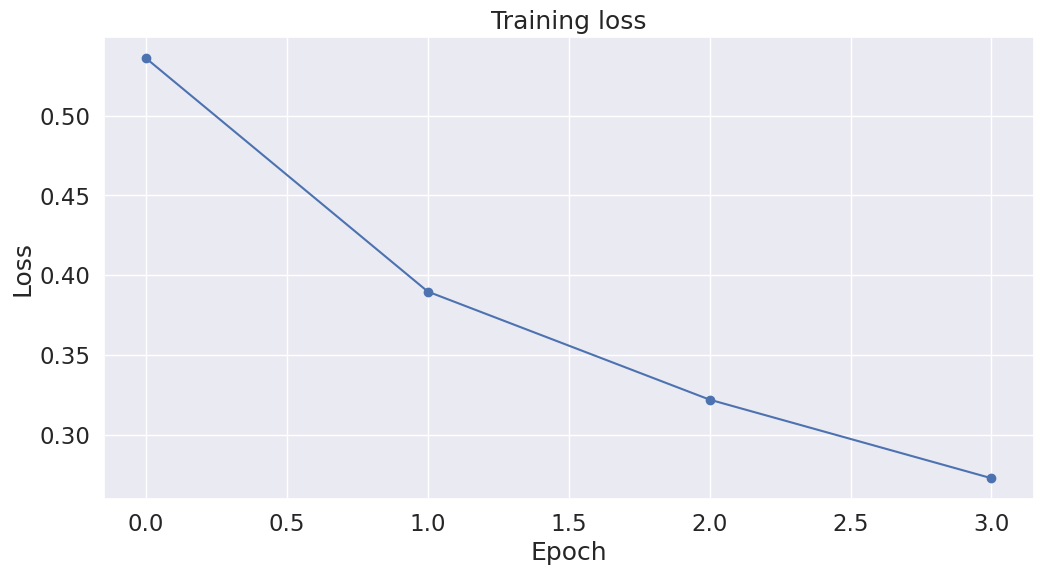

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()